## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

from IPython.display import clear_output
from random import sample

import matplotlib.pyplot as plt
import re

### Data loading: "Евгений Онегин"


In [2]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding="utf8") as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2021-04-28 17:13:11--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2021-04-28 17:13:12 (12.5 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

out = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
index_to_token = {
    idx: token
    for idx, token  in enumerate(tokens)
}

# dict <char>:<index>
token_to_index = {
    token: idx
    for idx, token  in enumerate(tokens)
}

the_whole_text_ids = [token_to_index[x] for x in out]

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [88]:
def generate_batch(texts_sequence, batch_size, sequence_length, dict_size):
    features = np.zeros((batch_size, sequence_length, dict_size), dtype=np.float32)
    targets = np.zeros((batch_size, sequence_length), dtype=np.float32)
    for i in range(batch_size):
        start_idx = np.random.randint(0, len(texts_sequence) - sequence_length)
        sub_sequence = texts_sequence[start_idx : start_idx + sequence_length]
        for j in range(len(sub_sequence)):
            features[i, j, sub_sequence[j]] = 1
            targets[i, j] = sub_sequence[j]
    return torch.from_numpy(features[:, :-1, :]), torch.Tensor(targets[:, 1:])

In [89]:
def plot_train_process(losses, epoches):
    clear_output(True)
    plt.figure(figsize=(10,7))
    plt.plot(epoches, loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Mean Loss")
    plt.show()

In [90]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(VanillaRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [91]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [187]:
args = dict()
args['input_size'] = len(token_to_index)
args['hidden_size'] = 128
args['layers'] = 2

args['epochs'] = 1200
args['lr'] = 1e-2

args['batch_size'] = 32
args['batch_length'] = 200

In [188]:
model = VanillaRNN(input_size=args['input_size'], output_size=args['input_size'], hidden_dim=args['hidden_size'], n_layers=args['layers'])
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

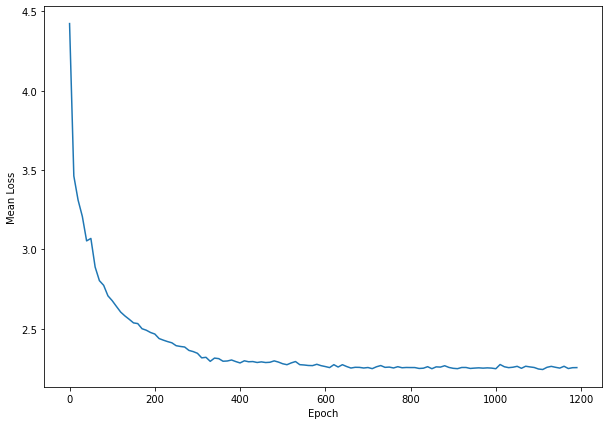

In [189]:
local_loss = []
loss_history = []
epoches = []

for epoch in range(args['epochs']):
    optimizer.zero_grad() 
    input_seq, target_seq = generate_batch(the_whole_text_ids, args['batch_size'], args['batch_length'], len(token_to_index))
    input_seq.to(device)
    output, hidden = model(input_seq)

    loss = criterion(output, target_seq.contiguous().view(-1).long())
    local_loss.append(loss.item())
    loss.backward()
    optimizer.step() 
    scheduler.step()
    
    if epoch % 10 == 0:
        loss_history.append(np.mean(local_loss))
        epoches.append(epoch)
        local_loss = []
        plot_train_process(loss_history, epoches)

In [190]:
def predict(model, phrase):
    x_sequence = [token_to_index[token] for token in phrase]
    features = np.zeros((1, len(phrase), dict_size), dtype=np.float32)
    for i in range(len(x_sequence)):
        features[0, i, x_sequence[i]] = 1
    features = torch.from_numpy(features)
    features.to(device)
    out, hidden = model(features)
    prob = nn.functional.softmax(out[-1], dim=0).data
    char_ind = torch.max(prob, dim=0)[1].item()
    return index_to_token[char_ind], hidden

In [191]:
def sample(model, max_len, seed_phrase=' но '):
    model.eval()
    seed_phrase = seed_phrase.lower()
    chars = [ch for ch in seed_phrase]
    for _ in range(max_len - len(seed_phrase)):
        char, h = predict(model, ''.join(chars))
        chars.append(char)
    return ''.join(chars)

In [195]:
sample(model, 50, 'сегодня утром ')

'сегодня утром он серенье не в ней востоной стровой'

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [70]:
def generate_batches(texts_sequence, batch_size, batch_length):

  x_train = []
  y_train = []
  for _ in range(batch_size):
    start_idx = np.random.randint(0, len(texts_sequence) - batch_length)
    sub_sequence = texts_sequence[start_idx : start_idx + batch_length]
    x_train.append(torch.tensor(sub_sequence[:-1]).view(-1, 1))
    y_train.append(torch.tensor(sub_sequence[1:]).view(-1, 1))

  return torch.stack(x_train, dim=0).permute(1, 0, 2), torch.stack(y_train, dim=0).permute(1, 0, 2)

In [71]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, embedding_size, n_layers=1):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(self.input_size, self.embedding_size)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.n_layers)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.hidden_size, self.input_size)
        
    def forward(self, x, hidden):
        x = self.encoder(x).squeeze(2)
        out, (ht1, ct1) = self.lstm(x, hidden)
        out = self.dropout(out)
        x = self.fc(out)
        return x, (ht1, ct1)
    
    def initial_state(self, batch_size=1):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True).to(device),
               torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True).to(device))

In [200]:
args = dict()
args['hidden_size'] = 128
args['embedding_size'] = 64
args['layers'] = 2

args['epochs'] = 300
args['lr'] = 1e-3

args['batch_size'] = 64
args['batch_length'] = 300

args['max_len'] = 500

In [197]:
model = LSTM(input_size=len(index_to_token), hidden_size=args['hidden_size'], embedding_size=args['embedding_size'], n_layers=args['layers'])
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], amsgrad=True)

In [198]:
def print_generated_sample(model, token_to_index, index_to_token, seed_phrase=' ', max_length=args['max_len'], temperature=1.0):
    
    model.eval()

    hidden = model.initial_state()
    x_sequence = [token_to_index[token] for token in seed_phrase]
    x_sequence = torch.LongTensor(x_sequence).view(-1, 1, 1).to(device)
    predicted_text = seed_phrase
    
    _, hidden = model(x_sequence, hidden)
    input = x_sequence[-1].view(-1, 1, 1)
    
    for i in range(max_length - len(seed_phrase)):
        output, hidden = model(input.to(device), hidden)
        output_logits = output.cpu().data.view(-1)
        p_next = F.softmax(output_logits / temperature, dim=-1).detach().cpu().data.numpy()        
        top_index = np.random.choice(len(token_to_index), p=p_next)
        input = torch.LongTensor([top_index]).view(-1, 1, 1).to(device)
        predicted_char = index_to_token[top_index]
        predicted_text += predicted_char
    
    return print(predicted_text)

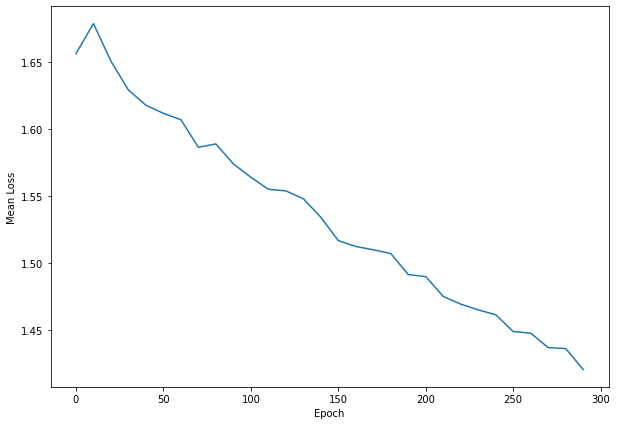

In [201]:
loss_history = []
epoches = []
local_loss = []

for epoch in range(args['epochs']):
    model.train()
    x_train, y_train = generate_batches(the_whole_text_ids, args['batch_size'], args['batch_length'])
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    hidden = model.initial_state(args['batch_size'])

    output, hidden = model(x_train, hidden)
    loss = criterion(output.permute(1, 2, 0), y_train.squeeze(-1).permute(1, 0))
    local_loss.append(loss.item())
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % 10 == 0:
        loss_history.append(np.mean(local_loss))
        epoches.append(epoch)
        local_loss = []
        plot_train_process(loss_history, epoches)
        

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [202]:
print_generated_sample(model, token_to_index, index_to_token, seed_phrase='но ', max_length=250, temperature=0.1)

но старины,
и в поле темною кони,
под ней на стал подобно он страстей,
в своей последнела разлуку,
на стол он подавался он
простите с ней сердце ей лет,
под ней на свете полон,
под ней нашел не под ней своей.



xxxii

покойно в своей полноты
привычк


In [203]:
print_generated_sample(model, token_to_index, index_to_token, seed_phrase='но ', max_length=250, temperature=0.2)

но старины,
и в собой обратилась волена,
в поле не прослаждала она.



xxii

и все дам под ним он волненье,
в нем он простодит на стал он.
не правда так небрежен,
когда ж не полном она своей.



xxxviii

неть умной волем невольна,
в только смертью по


In [204]:
print_generated_sample(model, token_to_index, index_to_token, seed_phrase='но ', max_length=250, temperature=0.5)

но старины
об ним одно об был он отдана,
в солне покоем. в шумный взгляда дева
с душе не подруги в руками
и таня пред нему свете старины,
господ волшебный под беда;
владемительных сон потом
владера бог их рожденный друг,
когда недавно искусит.
прости


In [205]:
print_generated_sample(model, token_to_index, index_to_token, seed_phrase='но ', max_length=250, temperature=1)

но звнуватся разночны
(чки дувстве над целой двор.
я к ним мелькать не пир долги
л; туж озора крик урким,
примерстин бале слова; и всем
пред вами в рука с ледящих,
лескатский! за собоей:
на утимает образ,
и, проходу беседом летят
и слыше была, не зна


In [206]:
print_generated_sample(model, token_to_index, index_to_token, seed_phrase='но ', max_length=250, temperature=2)

но лю
и…]ел хол:
ехунать: вошгешь: впырсночачи
вол. ланки иззбожеет!.! ккъя. звуч
с кровифахят: р’lаir» – мhагw
тежнил. ить в от яел…oю; прие, нея:
нидъянящий! каалапиг иким?,
друже?
сомньий. чте-тоб гоокртяетстжа, ея
ль уснезечь; вство он крясшуй;
г


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [306]:
import pickle

In [309]:
 with open("rnn_model.pkl", 'wb') as f:
        pickle.dump(model, f)

In [311]:
 with open("rnn_model.pkl", 'rb') as f:
    saved_model = pickle.load(f)

In [313]:
print_generated_sample(saved_model, token_to_index, index_to_token, seed_phrase='но ', max_length=500, temperature=0.5)

но любовь,
и брачею страстей,
и снег устах веделась не следеть
одначались в сердце в друзей,
и и природит садный старины,
беседа моей сердце томный,
в самое проволжал света,
с тобою нет ответа света,
и долго жизни молодой
не видя предметы стол на своей;
она в после мой деревенский,
молодой прости своей нет
и полно в поле забыла,
в семью нет полна сон.
но ей на дверь оставить,
он сердце желаний полной
он полнены крик испыльный лень
и безумном крестах на сием,
с своего сон обратцы
он полетел ли по


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)